# Model evaluation: sea ice

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.path as mpath
import numpy as np
%matplotlib inline
import pandas as pd
import glob
import os
from tqdm import tqdm_notebook

# To costumise subplots
import matplotlib.gridspec as gridspec

from datetime import timedelta

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36001/status,
Dashboard: /proxy/36001/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39711,Workers: 7
Dashboard: /proxy/36001/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:36079,Total threads: 4
Dashboard: /proxy/42125/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:33159,


In [18]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'
# 10% increase in easterly wind speed, meridional component only:
easterlies_up_mer = '01deg_jra55v13_ryf9091_easterlies_up10_meridional'
# 10% increase in easterly wind speed, zonal component only:
easterlies_up_zon = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'

# plot anomalies for 5 years, years 5-10 of simulation:
start_time = '2159-01-01' 
start_time_5 = '2155-01-01'
end_time   = '2159-12-31'

lat_slice  = slice(-80,-59)

In [4]:
fig_path   = '/g/data/x77/wgh581/Figures/Easterlies-Collab/'

In [5]:
# Plotting info
ft_size = 16
plt.rcParams.update({'font.size': ft_size})

### Observations


---

In [11]:
timerange = slice(pd.to_datetime('1979-01-01', format='%Y-%m-%d'),
                  pd.to_datetime('2021-12-31', format='%Y-%m-%d'))

In [20]:
def get_sic_obs(pattern, path='/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3', # from http://nsidc.org/data/G02202
                variable='goddard_merged_seaice_conc_monthly', timerange=timerange): 
    '''
    Return a dataarray from the nc files in path/pattern.
    '''
    dataarrays = []
    files = glob.glob(os.path.join(path, pattern))
    for f in tqdm_notebook(files, leave=False, desc='opening files'):
        dataarrays.append(xr.open_dataset(f, decode_times=False)[variable])
    dataarray = xr.concat(dataarrays, dim='time', coords='all')
    if 'time' in dataarray.coords:
        time_units = dataarray.time.units
        decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)
        dataarray.coords['time'] = ('time', decoded_time,
                                    {'long_name': 'time', 'decoded_using': time_units })

    # replace values outside valid range with nan
    dataarray = dataarray.where(np.ufuncs.logical_and(dataarray>=0, dataarray<=1)) #, np.nan)
    
    # use the same coord names as access-om2 t grid
    dataarray = dataarray.rename(({'xgrid': 'xt_ocean', 'ygrid': 'yt_ocean'}))
    
    # sort by time and select timerange
    dataarray = dataarray.sortby('time').sel(time=timerange)

    return dataarray

In [ ]:
obs_SH = get_sic_obs('south/monthly/*.nc', timerange=timerange)

---

Load previously calculated NSIDC datat (on OM2-025 grid, but that should be ok)

In [6]:
SH_sic_obs = xr.open_dataarray('/g/data/x77/wgh581/Post_Process/Observations/' + 'NSIDC_sic_1979_2019_monthly_SH_grid_OM2_025.nc')

In [10]:
# Sep and Feb value
SH_sic_obs_clim = SH_sic_obs.groupby('time.month').mean('time',skipna=True).sel(yt_ocean=slice(-90, -50)) 

### Model sea ice

In [36]:
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

In [39]:
seaice_control = cc.querying.getvar(control, 'aice_m', master_session, start_time=start_time_5, end_time=end_time, decode_coords=False)
seaice_control['time'] = seaice_control.time.to_pandas() - timedelta(hours = 12)
seaice_control.coords['ni'] = area_t['xt_ocean'].values
seaice_control.coords['nj'] = area_t['yt_ocean'].values
seaice_control = seaice_control.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
seaice_control = seaice_control.sel(yt_ocean=slice(-90,-50))
seaice_control = seaice_control.groupby('time.month').mean('time',skipna=True)

In [45]:
seaice_Wind_up = cc.querying.getvar(easterlies_up, 'aice_m', easterlies_session, start_time=start_time_5, end_time=end_time, decode_coords=False)
seaice_Wind_up['time'] = seaice_Wind_up.time.to_pandas() - timedelta(hours = 12)
seaice_Wind_up.coords['ni'] = area_t['xt_ocean'].values
seaice_Wind_up.coords['nj'] = area_t['yt_ocean'].values
seaice_Wind_up = seaice_Wind_up.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
seaice_Wind_up = seaice_Wind_up.sel(yt_ocean=slice(-90,-50))
seaice_Wind_up = seaice_Wind_up.groupby('time.month').mean('time',skipna=True)

In [46]:
seaice_Wind_down = cc.querying.getvar(easterlies_down, 'aice_m', easterlies_session, start_time=start_time_5, end_time=end_time, decode_coords=False)
seaice_Wind_down['time'] = seaice_Wind_down.time.to_pandas() - timedelta(hours = 12)
seaice_Wind_down.coords['ni'] = area_t['xt_ocean'].values
seaice_Wind_down.coords['nj'] = area_t['yt_ocean'].values
seaice_Wind_down = seaice_Wind_down.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
seaice_Wind_down = seaice_Wind_down.sel(yt_ocean=slice(-90,-50))
seaice_Wind_down = seaice_Wind_down.groupby('time.month').mean('time',skipna=True)

### Circumpolar plot of sea ice concentration

In [14]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5#0.455
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [26]:
# topography data for plotting:
ht = cc.querying.getvar(control, 'ht', master_session, n=1)
ht = ht.sel(yt_ocean=slice(-90,-50))  #
ht = ht.load()
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

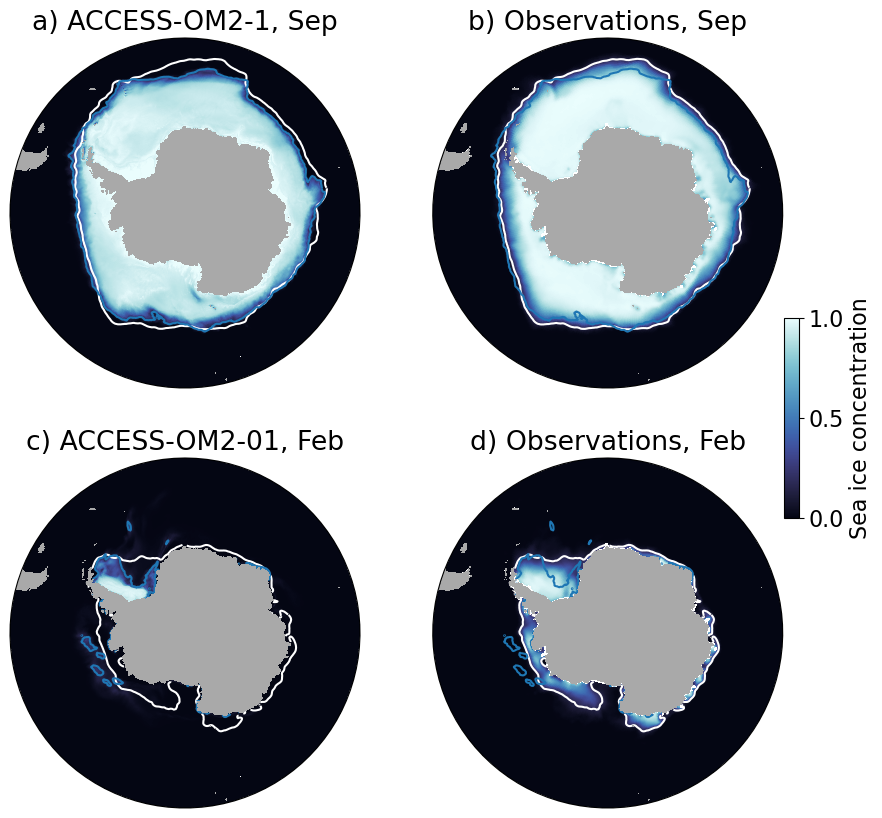

In [52]:
fig = plt.figure(figsize=(10,10))

## ACCESS Sep
ax = plt.subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
sc = seaice_control[8,...].plot.pcolormesh(transform=ccrs.PlateCarree(), cmap=cm.cm.ice, vmin=0, vmax=1, add_colorbar=False)
SH_sic_obs_clim[8,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors='w')
seaice_control[8,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors='C0')
#seaice_Wind_up[8,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors='C0')
#seaice_Wind_down[8,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors='C1')
ax.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree())

plt.title('a) ACCESS-OM2-1, Sep')

## Obs Sep
ax = plt.subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
sc = SH_sic_obs_clim[8,...].plot.pcolormesh(transform=ccrs.PlateCarree(), cmap=cm.cm.ice, vmin=0, vmax=1, add_colorbar=False)
SH_sic_obs_clim[8,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors='w')
seaice_control[8,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors='C0')
ax.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree())
plt.title('b) Observations, Sep')

## ACCESS Feb
ax = plt.subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
sc = seaice_control[1,...].plot.pcolormesh(transform=ccrs.PlateCarree(), cmap=cm.cm.ice, vmin=0, vmax=1, add_colorbar=False)
SH_sic_obs_clim[1,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors='w')
seaice_control[1,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors='C0')
ax.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree())
plt.title('c) ACCESS-OM2-01, Feb')

## Obs Feb
ax = plt.subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
sc = SH_sic_obs_clim[1,...].plot.pcolormesh(transform=ccrs.PlateCarree(), cmap=cm.cm.ice, vmin=0, vmax=1, add_colorbar=False)
SH_sic_obs_clim[1,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors='w')
seaice_control[1,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors='C0')
ax.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree())
plt.title('d) Observations, Feb')

# Colorbar
cbar_ax = fig.add_axes([0.9, 0.4, 0.015, 0.2])
cbar = plt.colorbar(sc, cax=cbar_ax, ticks=np.arange(0,1.1,0.5))
cbar.set_label('Sea ice concentration')

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'SuppFig_SeaIce.png'
    plt.savefig(fig_path + fig_name, dpi=300, bbox_inches='tight', facecolor='white');